In [1]:
import os
import sys
from pathlib import Path

cwd_path = cwd_path = Path(os.getcwd()).absolute().parents[0]
parent_path = cwd_path.parents[0]
sys.path.insert(0, parent_path.as_posix())
sys.path.insert(0, cwd_path.parents[0].parents[0].as_posix()) # Root

import numpy as np
from scipy.io import loadmat  # loading data from matlab
from mayavi import mlab
import matplotlib.pyplot as plt
from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsSequencing.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsSequencing.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsSequencing.skills.mps.gmr.manifold_gmr import manifold_gmr
from SkillsSequencing.utils.plot_sphere_mayavi import plot_sphere, plot_gaussian_mesh_on_tangent_plane

### Load Data

In [2]:
letter = 'C'
# exp_dir = './examples/MovementPrimitives/'
datapath = '2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)
demos = [d['pos'][0][0].T for d in data['demos'][0]]

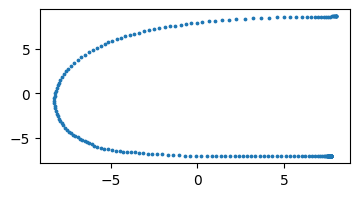

In [3]:
fig = plt.figure(figsize=(4,2))
plt.scatter(demos[2][:, 0], demos[2][:, 1], s=3)

### Parameters

In [4]:
nb_data = demos[0].shape[0]
nb_data_sup = 50
nb_samples = 5
dt = 0.06
input_dim = 3
output_dim = 3
in_idx = [0]
out_idx = [1, 2, 3]
nb_states = 3

In [5]:
# Create the manifold
input_manifold = Sphere(input_dim)
output_manifold = Euclidean(output_dim)
manifold = Product([input_manifold, output_manifold])

In [6]:
letter = 'C'
# exp_dir = './examples/MovementPrimitives/'
datapath = '2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)
demos = [d['pos'][0][0].T for d in data['demos'][0]]

In [7]:
demos = np.array(demos)
demos = 2 * demos / (np.max(demos, axis=1) - np.min(demos, axis=1))[:, None, :]
demos = np.concatenate((demos, np.ones((demos.shape[0], demos.shape[1], 1))), axis=2)
demos = demos / np.linalg.norm(demos, axis=2)[:, :, None]

In [8]:
demos.shape

(14, 200, 3)

In [9]:
target = input_manifold.log(demos[:, 2:, :], demos[:, :-2, :])
demos = demos[:, 1:-1, :]

In [33]:
nb_data = demos[0].shape[0]

In [10]:
X = demos[0]
for i in range(1, nb_samples):
    X = np.vstack([X, demos[i]])
Y = target[0]
for i in range(1, nb_samples):
    Y = np.vstack([Y, target[i]])

In [11]:
X.shape

(990, 3)

In [12]:
Y.shape

(990, 3)

In [15]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
        mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                      X[p * nb_data:(p + 1) * nb_data, 1],
                      X[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0.5, 0., 0.5),
                      scale_factor=0.03)
for p in range(nb_samples):
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      Y[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0., 0., 0.5),
                      scale_factor=0.03)
mlab.view(30, 30)
mlab.show()

In [35]:
# Data in format compatible with pymanopt product of manifolds
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(nb_data*nb_samples):
    data[n] = [X[n], Y[n]]

data = np.array(data, dtype=object)

In [36]:
data[0]

array([array([0.58176012, 0.60906998, 0.539063  ]),
       array([2.45400749e-18, 2.56920768e-18, 2.27390097e-18])],
      dtype=object)

In [18]:
nb_clusters = 3

# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / nb_data
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors
                                                                          )
# np.savez(filename, gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 29 iterations: 4.283e+01


In [99]:
Xt = X[-nb_data:]
Yt = Y[-nb_data:]

In [43]:
mu_gmr, sigma_gmr, H = manifold_gmr(Xt, manifold, gmm_means, gmm_covariances, gmm_priors)

In [65]:
rand_idx = np.random.choice(np.arange(0, len(X), nb_data))
# rand_idx = 0
Xt = np.copy(X[rand_idx:rand_idx+nb_data, :])
x0 = np.copy(X[rand_idx, :])
goal = np.copy(X[rand_idx+nb_data-1, :])
new_x = x0

## Xt

In [100]:
sampled_path = []
targets = []
dt = 1
for i in range(Xt.shape[0]):
#     pdb.set_trace()
    x_dot, sigma_gmr, H = manifold_gmr(Xt[i].reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = input_manifold.exp(Xt[i], dt * x_dot)
#     new_x = new_x / np.linalg.norm(new_x)
    sampled_path.append(new_x)
    targets.append(x_dot)
    
#     if np.linalg.norm(new_x - goal) <= 0.03:
#         break
sampled_path = np.array(sampled_path).squeeze(1)
true_path = X[rand_idx:rand_idx+nb_data]
print(rand_idx, len(sampled_path))

792 198


In [105]:
np.linalg.norm(Yt - targets)

7.778454209854347e-17

In [113]:
for i in range(11, 12):
    print(Yt[i], targets[i])

[2.43654212e-18 2.49712691e-18 2.37087026e-18] [[2.01396479e-18 3.40104122e-18 2.45381450e-18]]


In [86]:
sampled_path = []
dt = 5
for i in range(Xt.shape[0]):
#     pdb.set_trace()
    x_dot, sigma_gmr, H = manifold_gmr(new_x.reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = input_manifold.exp(new_x, dt * x_dot)
#     new_x = new_x / np.linalg.norm(new_x)
    
    sampled_path.append(new_x)
    
#     if np.linalg.norm(new_x - goal) <= 0.03:
#         break
sampled_path = np.array(sampled_path).squeeze(1)
true_path = X[rand_idx:rand_idx+nb_data]
print(rand_idx, len(sampled_path))

792 198


In [91]:
np.linalg.norm(new_x)

1.0

In [96]:
sampled_path

array([[ 0.5935706 ,  0.58362886,  0.55412209],
       [ 0.59399211,  0.58340327,  0.55390793],
       [ 0.59370359,  0.58355771,  0.55405455],
       [ 0.59229045,  0.58431244,  0.55477112],
       [ 0.59124768,  0.58486755,  0.55529824],
       [ 0.59016767,  0.58544092,  0.55584266],
       [ 0.5888434 ,  0.58614187,  0.556508  ],
       [ 0.5871665 ,  0.58702606,  0.55734721],
       [ 0.58517674,  0.58806996,  0.55833851],
       [ 0.58300651,  0.58920203,  0.55941432],
       [ 0.58073471,  0.59038046,  0.56053377],
       [ 0.57821928,  0.59167856,  0.56176413],
       [ 0.57521136,  0.59322043,  0.56322412],
       [ 0.57156394,  0.595071  ,  0.56498244],
       [ 0.56731391,  0.59719967,  0.5670163 ],
       [ 0.56246659,  0.59960085,  0.56930674],
       [ 0.5568522 ,  0.60236308,  0.57190415],
       [ 0.55021448,  0.60559066,  0.57491215],
       [ 0.54238872,  0.60929041,  0.57842862],
       [ 0.53340864,  0.6133418 ,  0.58248353],
       [ 0.52340857,  0.61762033,  0.587

In [13]:
sigma_gmr.shape

(250, 3, 3)

In [14]:
H.shape

(3, 250)

In [27]:
gmm_means

array([[array([-0.61646004, -0.03957806,  0.78639087]),
        array([-2.40989000e-18, -1.67404893e-19,  3.06747768e-18])],
       [array([ 0.40081264, -0.59622593,  0.69560324]),
        array([ 1.63047633e-18, -2.37630728e-18,  2.77050336e-18])],
       [array([0.24431076, 0.69859372, 0.67251697]),
        array([9.74096417e-19, 2.76596900e-18, 2.66104772e-18])]],
      dtype=object)

In [25]:
gmm_covariances.shape

(3, 6, 6)

In [17]:
mu_gmr.shape

(250, 3)

In [114]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                  X[p * nb_data:(p + 1) * nb_data, 1],
                  X[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0.4, 0., 0.),
                  scale_factor=0.03)

for p in range(len(sampled_path)):
    mlab.points3d(sampled_path[p, 0], sampled_path[p, 1], sampled_path[p, 2],
                  color=(0., 0.6, 0.),
                  scale_factor=0.03)

# Plot Gaussians
for k in range(nb_clusters):
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 0], gmm_covariances[k, :nb_clusters, :nb_clusters], color=(0., 0., 1.))

# # # Plot GMR trajectory
# for n in range(Xt.shape[0]):
#     # Plot mean and covariance
#     plot_gaussian_mesh_on_tangent_plane(mu_gmr[n], sigma_gmr[n], color=(0.20, 0.54, 0.93))
#     # Plot mean only
#     mlab.points3d(mu_gmr[n, 0], mu_gmr[n, 1], mu_gmr[n, 2],
#                   color=(0.20, 0.54, 0.93),
#                   scale_factor=0.03)
mlab.view(30, 120)
# mlab.savefig('Figure0.png')
mlab.show()

In [75]:
sampled_path[0]

array([0.5935706 , 0.58362886, 0.55412209])

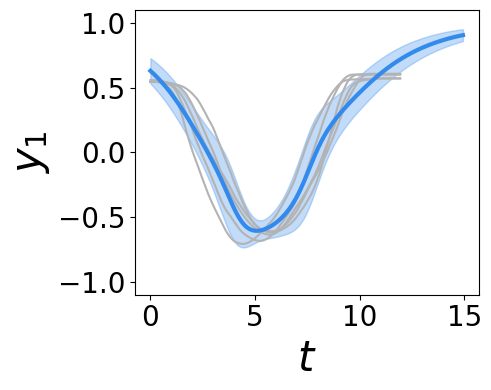

In [15]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 0], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 0], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 0] - np.sqrt(sigma_gmr[:, 0, 0])
maxy = mu_gmr[:, 0] + np.sqrt(sigma_gmr[:, 0, 0])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_1$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure1.png', dpi=100)

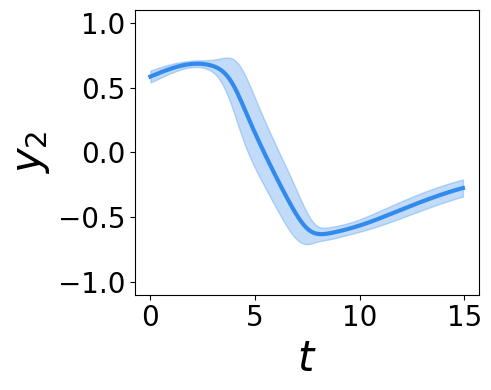

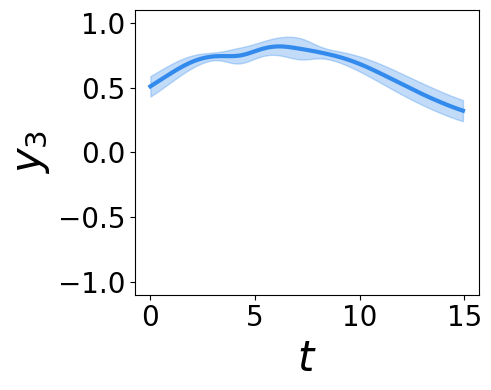

In [16]:
plt.figure(figsize=(5, 4))
# for p in range(nb_samples):
#     plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 1], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 1] - np.sqrt(sigma_gmr[:, 1, 1])
maxy = mu_gmr[:, 1] + np.sqrt(sigma_gmr[:, 1, 1])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure2.png', dpi=100)
# plt.show()

plt.figure(figsize=(5, 4))
# for p in range(nb_samples):
#     plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 2], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 2], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 2] - np.sqrt(sigma_gmr[:, 2, 2])
maxy = mu_gmr[:, 2] + np.sqrt(sigma_gmr[:, 2, 2])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_3$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure3.png', dpi=100)